In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from itertools import product

In [79]:
# Price for zero coupon bond
def ZCbond(F, r, t, T):
    return F*np.exp(-r*(T-t))

In [81]:
def rpoi(a, y, lam, T):
    return np.exp(lam * T * (np.exp(a) - 1) - a * y)

In [211]:
# MC with gamma distribution for the size of losses
def naive_MC_gamma(nr = 20000,lam=35,D=9000000000,T=1, k=1, th=163500000):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.gamma(shape=k, scale=th, size=poissons[i]))
        h.append(int(x>D))
    return np.cumsum(h)/np.arange(1,nr+1)

In [213]:
def rgamma(a, y, k, th, n):
    return (1-th*a)**(-k*n) / np.exp(a * y)

In [215]:
# Lognormal parameters for the target distribution
c_values = np.linspace(0.75, 1, 6)
d_values = np.linspace(1, 2.5, 4)  

import numpy as np

def MC_IS_gamma_poi(nr=20000, lam=35,D=9000000000,T=1, k=1, th=163500000, c=0.5, d=2):
    # Initial variables
    a_poi = np.log(c*D / (lam * T * k * th))
    poisson_means = lam * T * np.exp(a_poi)
    a_gamma = 1/th - (k * poisson_means)/(d*D)
    new_th = 1/(1/th - a_gamma)

    # Preallocate memory for cumulative sums
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_gamma = np.zeros(nr)
    
    # Loop over the number of simulations
    for i in range(nr):
        # Generate Poisson-distributed count
        poissons = np.random.poisson(lam=poisson_means)

        # Generate the exponential random variables for this count
        # Directly sum them without creating large intermediate arrays
        x = np.sum(np.random.gamma(shape=k, scale=new_th, size=poissons))

        # Compute h and r for this simulation
        h[i] = int(x > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_gamma[i] = rgamma(a_gamma, x, k, th, poissons)

    # Compute weighted values
    weighted_values = h * r_poi * r_gamma
    
    # Compute mean estimate
    mean_estimate = np.mean(weighted_values)
    
    # Compute variance of the estimator
    variance = np.var(weighted_values)/2

    return mean_estimate, variance

results = []

parameter_grid = list(product(c_values, d_values))

print(f"Total pairs of test: {len(parameter_grid)}")

for c,d in parameter_grid:
    
    if c < d:
        # Compute mean and variance of the estimator
        mean_estimate, variance = MC_IS_gamma_poi(nr=20000, lam=35,D=9000000000,T=1, k=1, th=163500000, c=c, d=d)
    
        results.append((c, d, mean_estimate, variance))

# Display results
print(f"{'c':>5} | {'d':>5} | {'Mean Estimate':>15} | {'Variance':>10}")
print("-" * 45)
for c, d, mean_estimate, variance in results:
    print(f"{c:>5.2f} |{d:>5.2f} | {mean_estimate:>15.5f} | {variance:>10.7f}")

Total pairs of test: 30
    c |     d |   Mean Estimate |   Variance
---------------------------------------------
 0.75 | 1.00 |         0.01480 |  0.0004901
 0.75 | 1.50 |         0.02692 |  2.1532766
 0.75 | 2.00 |         0.00760 |  0.3398118
 0.75 | 2.50 |         0.00118 |  0.0103123
 0.75 | 3.00 |         0.00006 |  0.0000103
 0.80 | 1.00 |         0.01474 |  0.0003222
 0.80 | 1.50 |         0.01428 |  0.0271501
 0.80 | 2.00 |         0.00656 |  0.0499146
 0.80 | 2.50 |         0.00180 |  0.0099837
 0.80 | 3.00 |         0.00001 |  0.0000004
 0.85 | 1.00 |         0.01463 |  0.0004981
 0.85 | 1.50 |         0.01425 |  0.0080998
 0.85 | 2.00 |         0.02605 |  1.5128946
 0.85 | 2.50 |         0.00065 |  0.0021274
 0.85 | 3.00 |         0.00230 |  0.0334267
 0.90 | 1.00 |         0.01488 |  0.0015769
 0.90 | 1.50 |         0.01477 |  0.0039198
 0.90 | 2.00 |         0.00971 |  0.0564095
 0.90 | 2.50 |         0.01860 |  2.7338527
 0.90 | 3.00 |         0.00004 |  0.0000055
 0.95

In [217]:
# Importance sampling for default probability
def MC_IS_gamma_poi(nr=20000, lam=35,D=9000000000,T=1, k=1, th=163500000):
    # Initial variables
    a_poi = np.log(0.8*D / (lam * T * k * th))
    poisson_means = lam * T * np.exp(a_poi)
    a_gamma = 1/th - (k * poisson_means)/D
    new_th = 1/(1/th - a_gamma)

    # Preallocate memory for cumulative sums
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_gamma = np.zeros(nr)
    
    # Loop over the number of simulations
    for i in range(nr):
        # Generate Poisson-distributed count
        poissons = np.random.poisson(lam=poisson_means)

        # Generate the exponential random variables for this count
        # Directly sum them without creating large intermediate arrays
        x = np.sum(np.random.gamma(shape=k, scale=new_th, size=poissons))

        # Compute h and r for this simulation
        h[i] = int(x > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_gamma[i] = rgamma(a_gamma, x, k, th, poissons)

    # Calculate cumulative sum and return the average at each step
    cumulative_sum = np.cumsum(h * r_poi * r_gamma)
    cumulative_avg = cumulative_sum / np.arange(1, nr + 1)

    return cumulative_avg

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


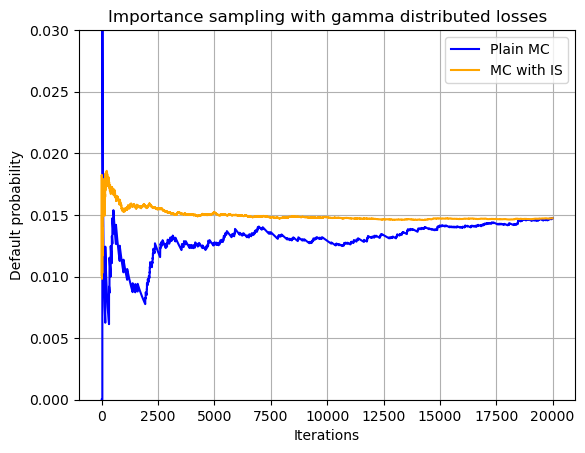

In [227]:
plt.plot(naive_MC_gamma(),color = "blue",label = "Plain MC")
plt.plot(MC_IS_gamma_poi(),color = "orange",label = "MC with IS")
plt.title("Importance sampling with gamma distributed losses")
plt.ylim([0,0.03])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.savefig('IS_gamma.eps', format='eps')
plt.show()

In [259]:
# MC with lognormal distribution for the size of losses
def naive_MC_log(nr = 20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.lognormal(mean=mu, sigma=sig, size = poissons[i]))
        h.append(int(x>D))
    return np.cumsum(h)/np.arange(1,nr+1)

In [261]:
def rlog(a, y, mu, sig, n):
    return np.exp(((mu+a)**2-mu**2)/(2*sig**2))**n / np.exp(a * y/(sig**2))

def rlog2(a, b, y, z, mu, sig, n):
    new_mu = mu+a
    new_sig = sig*b
    return b*np.exp((1/(2*new_sig**2)-1/(2*sig**2))*z) * np.exp((mu/sig**2 - new_mu/new_sig**2)*y) * np.exp(new_mu**2/(2*new_sig**2) - mu**2/(2*sig**2))**n

In [285]:
# Lognormal parameters for the target distribution
c_values = np.linspace(0.7, 0.9, 5)
d_values = np.linspace(1, 1.4, 5)

import numpy as np

def MC_IS_log_poi(nr=20000, lam=35,D=9000000000,T=1, mu=18.4, sig=1, c=0.25, d=2):
    # Initial variable
    a_poi = np.log(c*D / (lam * T * np.exp(mu+sig**2/2)))
    poisson_means = lam * T * np.exp(a_poi)
    a_log = np.log(d*D/poisson_means) - (mu+sig**2/2)
    new_mu = mu+a_log

    # Preallocate memory
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_log = np.zeros(nr)
    
    # Loop over simulations
    for i in range(nr):
        poissons = np.random.poisson(lam=poisson_means)
        x = np.random.normal(loc=new_mu, scale=sig, size=poissons)
        y = np.sum(x)
        z = np.sum(np.exp(x))

        h[i] = int(z > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_log[i] = rlog(a_log, y, mu, sig, poissons)

    # Compute weighted values
    weighted_values = h * r_poi * r_log
    
    # Compute mean estimate
    mean_estimate = np.mean(weighted_values)
    
    # Compute variance of the estimator
    variance = np.var(weighted_values)/2

    return mean_estimate, variance

results = []

parameter_grid = list(product(c_values, d_values))

print(f"Total pairs of test: {len(parameter_grid)}")

for c,d in parameter_grid:
    
    if c < d:
    
        # Compute mean and variance of the estimator
        mean_estimate, variance = MC_IS_log_poi(nr=20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1, c=c, d=d)
    
        results.append((c, d, mean_estimate, variance))

# Display results
print(f"{'c':>5} | {'d':>5} | {'Mean Estimate':>15} | {'Variance':>15}")
print("-" * 45)
for c, d, mean_estimate, variance in results:
    print(f"{c:>5.2f} | {d:>5.2f} | {mean_estimate:>15.5f} | {variance:>15.7f}")

Total pairs of test: 25


/var/folders/sd/d_f77w3s46j31xyf9sbp909h0000gn/T/ipykernel_27428/803118573.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(((mu+a)**2-mu**2)/(2*sig**2))**n / np.exp(a * y/(sig**2))
/var/folders/sd/d_f77w3s46j31xyf9sbp909h0000gn/T/ipykernel_27428/803118573.py:2: RuntimeWarning: overflow encountered in scalar power
  return np.exp(((mu+a)**2-mu**2)/(2*sig**2))**n / np.exp(a * y/(sig**2))
/var/folders/sd/d_f77w3s46j31xyf9sbp909h0000gn/T/ipykernel_27428/803118573.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(((mu+a)**2-mu**2)/(2*sig**2))**n / np.exp(a * y/(sig**2))


    c |     d |   Mean Estimate |        Variance
---------------------------------------------
 0.70 |  1.00 |         0.03322 |       0.1139546
 0.70 |  1.10 |         0.02576 |       0.0308903
 0.70 |  1.20 |         0.02339 |       0.0341055
 0.70 |  1.30 |             nan |             nan
 0.70 |  1.40 |             nan |             nan
 0.75 |  1.00 |         0.02757 |       0.0061405
 0.75 |  1.10 |         0.03768 |       0.1694195
 0.75 |  1.20 |         0.02865 |       0.0456230
 0.75 |  1.30 |             nan |             nan
 0.75 |  1.40 |             nan |             nan
 0.80 |  1.00 |         0.02892 |       0.0076156
 0.80 |  1.10 |         0.03156 |       0.0198900
 0.80 |  1.20 |         0.03219 |       0.0820375
 0.80 |  1.30 |         0.02865 |       0.0877224
 0.80 |  1.40 |             nan |             nan
 0.85 |  1.00 |         0.03394 |       0.0441596
 0.85 |  1.10 |         0.03193 |       0.1009149
 0.85 |  1.20 |         0.02765 |       0.0178746
 0.8

In [287]:
# Importance sampling for default probability
def MC_IS_log_poi(nr=20000, lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    # Initial variables
    a_poi = np.log(0.75 * D / (lam * T * np.exp(mu+sig**2/2)))
    poisson_means = lam * T * np.exp(a_poi)
    a_log = np.log(D/poisson_means) - (mu+sig**2/2)
    new_mu = mu+a_log

    # Preallocate memory for cumulative sums
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_log = np.zeros(nr)
    
    # Loop over the number of simulations
    for i in range(nr):
        # Generate Poisson-distributed count
        poissons = np.random.poisson(lam=poisson_means)

        # Generate the exponential random variables for this count
        # Directly sum them without creating large intermediate arrays
        x = np.random.normal(loc=new_mu, scale=sig, size=poissons)
        y = np.sum(x)
        z = np.sum(np.exp(x))

        # Compute h and r for this simulation
        h[i] = int(z > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_log[i] = rlog(a_log, y, mu, sig, poissons)

    # Calculate cumulative sum and return the average at each step
    cumulative_sum = np.cumsum(h * r_poi * r_log)
    cumulative_avg = cumulative_sum / np.arange(1, nr + 1)

    return cumulative_avg

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


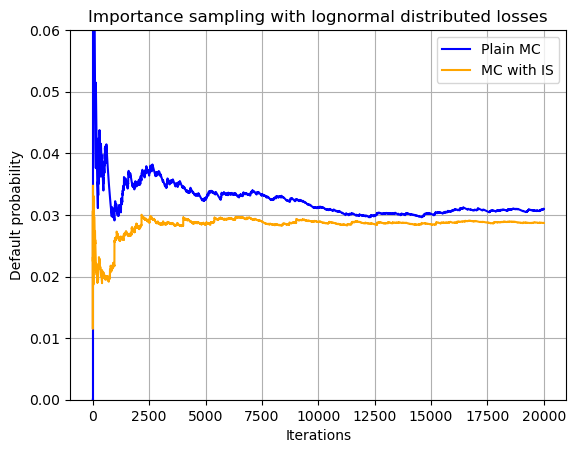

In [305]:
plt.plot(naive_MC_log(),color = "blue",label = "Plain MC")
plt.plot(MC_IS_log_poi(),color = "orange",label = "MC with IS")
plt.title("Importance sampling with lognormal distributed losses")
plt.ylim([0,0.06])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.savefig('IS_lognormal.eps', format='eps')
plt.show()